## **Social Media Analytics (SMA) SoSe24 -  Capstone Project**
### **The General Info & Data Engineering Part**

#### `Name & Surname: Abdulkadir Arslan`

## **The Content of My Capstone Project**

### **My Task (A Fictitious Scenario)** 

###### *Note:* I previously detailed a fictitious scenario in the Capstone Project Proposal, but here, I aimed to present it in a more concise and general manner.

##### As a data scientist at a tech company specializing in electronic devices, I am responsible for providing the marketing team with actionable insights into user and potential customer behavior for our latest product, the GoPro Hero 12. These insights will serve as a guide to enhance customer satisfaction and boost sales.

### **The Data**

##### To accomplish the task, I developed a comprehensive strategy focused on collecting YouTube comments from videos about the GoPro Hero 12, creating a data set from these comments, and then processing and analyzing it. Therefore, the project utilizes a real-world data set that I retrieved using the YouTube Data API. Furthermore, this methodology can be adapted for any other product with relevant YouTube videos. 

### **Data Engineering & Analysis**

##### I splited my capstone project into two parts as Data Engineering Part and Analytical Part and submitted them in two different Jupyter Notebooks respectively called `data_engineering_capstone.ipynb` and `analytics_capstone.ipynb`. You are in the `data_engineering_capstone.ipynb` file.

##### The following steps were undertaken to create the dataset, explore it, and prepare it for further analysis to gain actionable insights about the product.

##### Data Engireening Part:

- Initially, "GoPro HERO12 English reviews" search was made to find the targeted videos for the project. To determine which videos' comments would be analyzed, the search results were filtered wisely and essential data of the selected videos was fetched by referencing video IDs. After selecting the targeted videos, the video comments and these comments' metadata were extracted. Subsequently, initial exploratory data analysis was conducted to gain insights into the collected data, followed by preprocessing to prepare it for further analysis.

##### Analytical Part:

- This part explained in detail in `analytics_capstone.ipynb` file.

Each step of these two parts is explained in detail during the project work. These steps are indicated by roman numerals.

### **Reporting and Recommendations**

##### Finally, I created a report to summarize the findings, and then, I provided recommendations based on the report to help the marketing team to improve their strategies. This also is provided in `analytics_capstone.ipynb` file.

**NOTE:** I submitted two CSV files: 'original_comments.csv' and 'processed_comments.csv'. For the analytical part, I utilized the data from 'processed_comments.csv', which underwent preprocessing. The raw dataset retrieved using the YouTube Data API was also submitted additionally in case you would like to review it.

## **The Packages**

In [1]:
import os
from googleapiclient.discovery import build
import re
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

**i.** *Top-viewed `GoPro HERO12 English Review` YouTube Videos Analysis:*

This step aims to identify and list the top-viewed YouTube videos related to "GoPro HERO12 English reviews" search while excluding shorts (videos shorter than 60 seconds). It searches for videos using the YouTube Data API, filters results to include only those with "GoPro," "Hero," and "12" in their titles, and checks the duration of each video to ensure they are over 60 seconds long. The final output is a list of video IDs (saved in youtube_video_ids variable) for the top 10 viewed videos meeting these criteria. 

I used the following source to learn how to use YouTube Data API and I also used some code from the source. [The link for the source](https://medium.com/mcd-unison/youtube-data-api-v3-in-python-tutorial-with-examples-e829a25d2ebd)

In [2]:
api_key = os.getenv("YOUTUBE_API_KEY")

youtube = build("youtube", "v3", developerKey=api_key)

search_query = "GoPro HERO12 English reviews"

response = youtube.search().list(
    q=search_query,
    type="video",
    part="id,snippet",
    order="viewCount",
    maxResults=50
).execute()

youtube_video_ids = []

for item in response["items"]:
    video_id = item["id"]["videoId"]
    title = item["snippet"]["title"]
    
    if "gopro" in title.lower() and "hero" in title.lower() and "12" in title:
        api_resp = youtube.videos().list(
            part="contentDetails",
            id=video_id
        ).execute()

        if "items" in api_resp:
            video_duration = api_resp["items"][0]["contentDetails"]["duration"]
            # Convert the video duration to seconds (PTXHXM format)
            duration_seconds = 0
            if 'H' in video_duration:
                hours, minutes, seconds = re.findall(r'(\d+)H(\d+)M(\d+)S', video_duration)[0]
                duration_seconds = int(hours) * 3600 + int(minutes) * 60 + int(seconds)
            elif 'M' in video_duration and 'S' in video_duration:
                minutes, seconds = re.findall(r'(\d+)M(\d+)S', video_duration)[0]
                duration_seconds = int(minutes) * 60 + int(seconds)
            elif 'S' in video_duration:
                seconds = re.findall(r'(\d+)S', video_duration)[0]
                duration_seconds = int(seconds)

            if duration_seconds >= 60: 
                youtube_video_ids.append(video_id)

print("Top 10 Viewed YouTube Video IDs (YouTube Shorts Excluded!):")
for video_id in youtube_video_ids[:10]:
    print(video_id)


Top 10 Viewed YouTube Video IDs (YouTube Shorts Excluded!):
UZ5G0tVwBkI
V77fitugloQ
IEfFk5GR5y0
Ao49eJKV37c
IbzJVWV4pAo
sgT-ZNTaRCA
L0_No2s8rIs
rta2YW-uZU4
Bg-uvYKO4-g
7QHPHWPGaPA


- Searching for 'GoPro HERO12 English Review' is necessary because searching only 'GoPro HERO12' may yield videos in other languages depending on your location, number of views, and other factors. Consequently, the comments on these videos will also be in the same language as the video's language but I considered only English videos and their comments. In addition, when not adding the 'Review' on the search query, unnecessary and unrelated types of content related to the camera occur.

- Excluding YouTube Shorts videos is necessary because they are primarily for entertainment purposes and typically lack considerable comments related to the product.

- Filtering videos to include only those with "GoPro," "Hero," and "12" in their titles is necessary to exclude results related to previous models of the camera.

- The limitation of the 10 top-viewed videos is that the rest of the videos do not have a considerable number of comments.

**ii.** *Analyzing Engagement Metrics of `GoPro HERO12 English Review` Top 10 Viewed YouTube Videos:*

This step aims to gather additional statistics (views, likes, and comments) for the previously identified top-viewed GoPro Hero 12 review videos on YouTube for the general interaction. It iterates through the video IDs, retrieves their statistics using the YouTube Data API, and stores this information in a list. This data is then converted into a pandas DataFrame and sorted by the number of comments to highlight the most engaging videos. The resulting DataFrame displays the top 10 videos with their respective view, like, and comment counts, sorted by the number of comments.

In [3]:
youtube_video_data = []

for video_id in youtube_video_ids:
    api_resp = youtube.videos().list(
        part="statistics",
        id=video_id
    ).execute()

    if api_resp.get("items"):
        video_info = api_resp["items"][0]
        video_stats = video_info["statistics"]

        video_views = int(video_stats.get("viewCount", 0))
        video_likes = int(video_stats.get("likeCount", 0))
        video_comments = int(video_stats.get("commentCount", 0))

        youtube_video_data.append({
            "video_id": video_id,
            "no_of_views": video_views,
            "no_of_likes": video_likes,
            "no_of_comments": video_comments
        })

df_video_data = pd.DataFrame(youtube_video_data)

df_video_data.head(10).sort_values(by='no_of_comments', ascending=False)

,video_id,no_of_views,no_of_likes,no_of_comments
0,UZ5G0tVwBkI,1975484,39770,3160
2,IEfFk5GR5y0,677784,12632,742
1,V77fitugloQ,922995,11133,675
5,sgT-ZNTaRCA,245937,4714,525
3,Ao49eJKV37c,450341,14904,494
7,rta2YW-uZU4,82460,2228,457
4,IbzJVWV4pAo,294963,7686,280
6,L0_No2s8rIs,135894,1809,231
8,Bg-uvYKO4-g,80755,1158,136
9,7QHPHWPGaPA,39601,674,107


**iii.** *Visualizing Engagement Metrics for `GoPro HERO12 English Review` Top 10 Viewed YouTube Videos:*

This step aims to visualize engagement metrics from the previous step. It creates three bar charts in a single figure, each chart displaying the number of views, likes, and comments per video, respectively. The visualizations help to compare and understand the relative popularity and engagement of each video.

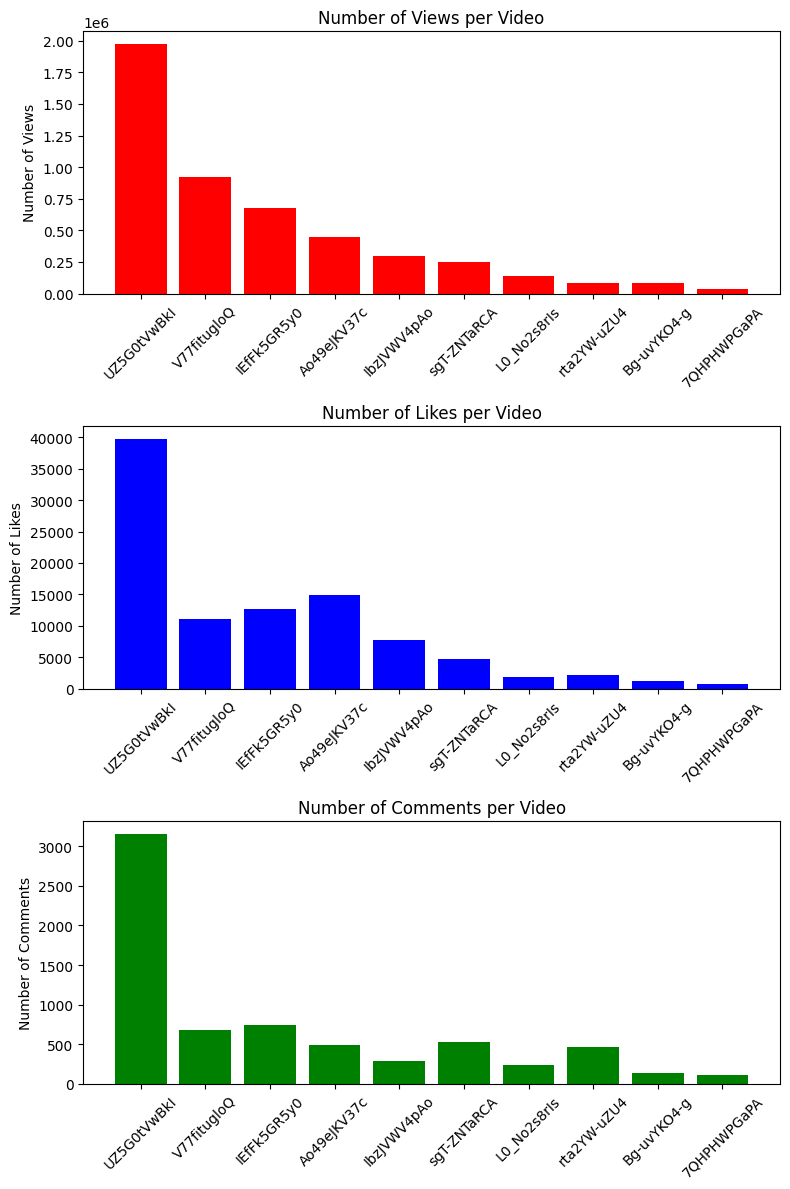

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

axes[0].bar(df_video_data["video_id"].head(10), df_video_data["no_of_views"].head(10), color="r")
axes[0].set_ylabel("Number of Views")
axes[0].set_title("Number of Views per Video")
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(df_video_data["video_id"].head(10), df_video_data["no_of_likes"].head(10), color="b")
axes[1].set_ylabel("Number of Likes")
axes[1].set_title("Number of Likes per Video")
axes[1].tick_params(axis='x', rotation=45)

axes[2].bar(df_video_data["video_id"].head(10), df_video_data["no_of_comments"].head(10), color="g")
axes[2].set_ylabel("Number of Comments")
axes[2].set_title("Number of Comments per Video")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

The engagement metric visualizations show that higher view counts do not necessarily correlate with higher likes or comments. Some videos with fewer views have relatively high numbers of likes or comments, indicating that engagement is not solely dependent on view count. Similarly, videos with a high number of likes do not always have the highest view counts or comments, suggesting that viewer engagement varies independently across these metrics. Overall, the data shows that viewership, likes, and comments are distinct forms of engagement and do not always increase together.

**iv.** *Extracting Comments from `GoPro HERO12 English Review` Top 10 Viewed YouTube Videos:*

This step aims to retrieve all comments for the top 10 GoPro Hero 12 review videos on YouTube. It defines a function (get_all_video_comments) to fetch comments using the YouTube Data API, iterating through all pages of comments for each video ID. The collected data includes the video ID, author, publication and update timestamps, like count, and comment text. The comments are then consolidated into a pandas DataFrame and saved as a CSV file named 'original_comments.csv'. This process results in a comprehensive dataset of comments for further analysis.

In [5]:
def get_all_video_comments(video_id):
    comments_data = []
    nextPageToken = None

    while True:
        response = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=100,
            pageToken=nextPageToken,
            textFormat="plainText"
        ).execute()

        for item in response["items"]:
            comment = item["snippet"]["topLevelComment"]["snippet"]
            comments_data.append({
                "video_id": video_id,
                "author": comment["authorDisplayName"],
                "published_at": comment["publishedAt"],
                "updated_at": comment["updatedAt"],
                "like_count": comment["likeCount"],
                "comment_text": comment["textDisplay"]
            })

        nextPageToken = response.get("nextPageToken")

        if not nextPageToken:
            break

    return comments_data

all_comments_data = []
for video_id in youtube_video_ids[:10]:
    comments = get_all_video_comments(video_id)
    all_comments_data.extend(comments)

df_video_comments = pd.DataFrame(all_comments_data)

df_video_comments.to_csv('original_comments.csv', index=False)

df_video_comments

,video_id,author,published_at,updated_at,like_count,comment_text
0,UZ5G0tVwBkI,@rosta2899,2024-06-27T16:14:42Z,2024-06-27T16:14:42Z,0,Does this camera record without a battery and ...
1,UZ5G0tVwBkI,@DarkpawTheWolf,2024-06-24T18:47:07Z,2024-06-24T18:47:07Z,0,@gopro When are we getting the Hero 13 Black? ...
2,UZ5G0tVwBkI,@ohdogwow2,2024-06-17T22:31:56Z,2024-06-17T22:31:56Z,0,"But, can it run Crysis?"
3,UZ5G0tVwBkI,@MARLONSKI8,2024-06-13T03:51:07Z,2024-06-13T03:51:07Z,0,Build in an Iphone Camera
4,UZ5G0tVwBkI,@diegogorrieri4153,2024-06-12T21:11:45Z,2024-06-12T21:11:45Z,0,No GPS such a good idea. \nIf only I knew that...
...,...,...,...,...,...,...
4984,7QHPHWPGaPA,@timoklap,2024-02-02T10:27:04Z,2024-02-05T04:27:27Z,8,After fan of gopro since 2011 with 5 generatio...
4985,7QHPHWPGaPA,@MOTOUK1,2024-02-02T10:26:51Z,2024-02-02T10:26:51Z,7,I stopped using GoPro years ago when too many ...
4986,7QHPHWPGaPA,@JandyElijahYT,2024-02-02T10:12:54Z,2024-02-02T10:12:54Z,0,Gopro is fine for me
4987,7QHPHWPGaPA,@lupo10,2024-02-02T10:03:59Z,2024-02-02T10:03:59Z,0,"I bought one, just like my Hero 4 Silver - I j..."


In the following two code cells, I respectively dropped the unnecasary features of the data set and checked the data types of selected columns and if there is any missing values in these columns.

- The commentator name and the like count of the comments are not a part of my project so I dropped them.

- I selected the 'updated_at' column instead of 'published_at' because it reflects the time of the final thoughts of the commentator. 

- There is not any missing value in the data set and data types are objects. 

- The total number of comments decreased from 6807 to 4989 after extracting comments from the videos. This reduction occurred because YouTube includes all comments and replies in its total count for a video, whereas the extraction process focuses only on primary comments without including their replies.

In [6]:
df_video_comments = df_video_comments.drop(['author', 'published_at', 'like_count'], axis=1)

In [7]:
df_video_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4989 entries, 0 to 4988
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   video_id      4989 non-null   object
 1   updated_at    4989 non-null   object
 2   comment_text  4989 non-null   object
dtypes: object(3)
memory usage: 117.1+ KB


**v.** *Processing the Comment Dataset (df_video_comments) for Subsequent Analysis:*

This is the last step of Data Engineering and in this step, I performed the followings;

- Ensuring that the dataset is prepared with only English-language comments for further analytical tasks (language detection).

- Preprocessing the text for comment data enhancement.

In the following code cell, the code snippet for language detection aims to filter and preprocess comments from a DataFrame (df_video_comments) to include only those in English. It defines a function (det_non_eng) using the langdetect library to detect the language of each comment. The function applies this detection to the 'comment_text' column of the DataFrame. Comments identified as non-English are filtered out by creating a new DataFrame (df_video_comments) that retains only English comments. The 'non_eng' column, used temporarily for language detection, is then dropped from the DataFrame, and the index is reset for clarity and consistency in subsequent analysis. This process ensures that the dataset is prepared with only English-language comments for further analytical tasks.

In [8]:
def det_non_eng(text):
    try:
        lang = detect(text)
        return lang
    except:
        return "unknown"

df_video_comments['non_eng'] = df_video_comments['comment_text'].apply(det_non_eng)

df_video_comments = df_video_comments[df_video_comments['non_eng'] == 'en']

df_video_comments.drop('non_eng', axis=1, inplace=True)

df_video_comments.reset_index(drop=True, inplace=True)

In [9]:
df_video_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   video_id      4200 non-null   object
 1   updated_at    4200 non-null   object
 2   comment_text  4200 non-null   object
dtypes: object(3)
memory usage: 98.6+ KB


In [10]:
df_video_comments.groupby('video_id').size().reset_index(name='no_of_comments').sort_values(by='no_of_comments', ascending=False)

,video_id,no_of_comments
6,UZ5G0tVwBkI,1803
3,IEfFk5GR5y0,517
7,V77fitugloQ,476
8,rta2YW-uZU4,328
9,sgT-ZNTaRCA,314
1,Ao49eJKV37c,312
4,IbzJVWV4pAo,183
5,L0_No2s8rIs,137
0,7QHPHWPGaPA,75
2,Bg-uvYKO4-g,55


The total video comments count decreased from 4989 to 4200 after filtering out the non-English comments and it also effected the videos' individual comments numbers as expected

In the following code cell, the code snippet for preprocessing comment text aims to preprocess text data from the 'comment_text' column in the DataFrame df_video_comments. It first converts all text to lowercase and tokenizes each comment into individual words. Stopwords and non-alphabetic tokens are removed from the tokens list. Using the spaCy library with a preloaded English model (en_core_web_sm), it performs lemmatization on the remaining tokens to reduce them to their base forms. The processed text is then stored back into the 'comment_text' column. Finally, the DataFrame is saved as 'processed_comments.csv', containing the preprocessed comments ready for further analysis. This preprocessing enhances the quality of text data by standardizing formats and reducing variability for more effective analysis tasks.

In [11]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_text(text):
    text = text.lower()
    
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    
    text = ' '.join([token.lemma_ for token in nlp(' '.join(tokens))])
    
    return text

In [12]:
df_video_comments["comment_text"] = df_video_comments["comment_text"].apply(preprocess_text)

df_video_comments.to_csv('processed_comments.csv', index=False)

df_video_comments

,video_id,updated_at,comment_text
0,UZ5G0tVwBkI,2024-06-27T16:14:42Z,camera record without battery connect adapter
1,UZ5G0tVwBkI,2024-06-24T18:47:07Z,gopro get hero black update quality must
2,UZ5G0tVwBkI,2024-06-17T22:31:56Z,run crysis
3,UZ5G0tVwBkI,2024-06-13T03:51:07Z,build iphone camera
4,UZ5G0tVwBkI,2024-06-12T21:11:45Z,gps good idea know never waste money camera re...
...,...,...,...
4195,7QHPHWPGaPA,2024-02-02T10:31:21Z,really like recording refreame scene want use ...
4196,7QHPHWPGaPA,2024-02-05T04:27:27Z,fan gopro since generation camera enogh switch...
4197,7QHPHWPGaPA,2024-02-02T10:26:51Z,stop use gopro year ago many corrupt card issu...
4198,7QHPHWPGaPA,2024-02-02T10:12:54Z,gopro fine


In [15]:
df_video_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   video_id      4200 non-null   object
 1   updated_at    4200 non-null   object
 2   comment_text  4200 non-null   object
dtypes: object(3)
memory usage: 98.6+ KB


The changes from lowercasing, tokenization, lemmatization, and removing stopwords and non-alphabetic tokens can be clearly seen in the 'comment_text' column in the 'df_video_comments' DataFrame. Additionally, there are no changes in the total number of comments after preprocessing.